# Deep neural network under-sampled image reconstruction for X-Ray tomography

##  Imports

In [1]:
import spyrit

In [2]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import torch.nn.functional as F
import cv2
import fht
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.io as sio
import scipy.linalg as lin
from PIL import Image, ImageOps
from pathlib import Path
import matplotlib.pyplot as plt
import sys
from pathlib import Path
import model_Radon_DCAN as model_radon
import h5py as h5
from skimage.data import shepp_logan_phantom
from skimage.transform import radon, rescale
import time

## Considered parameters

In [3]:
#- Acquisition
img_size = 64 # image size
pixel_size = 64 #Number of pixels of the sensor

#- Using CPU or GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# 1 - Computed Tomography (CT) and Radon operator

## Computed Tomography (CT)
Computed tomography (CT) is an imaging modality that reconstructs 2D or 3D objects from attenuation measurements. CT is a technique used in non-destructive inspection but most notably in medical imaging, where attenuation allows the type of tissue (e.g., bone, soft tissue) and structures (e.g., tumors) to be identified. The image formation process can be modelled by the Radon transform.

## Radon transform
The Radon transform is an integral transform that returns line integrals over hyperplanes (e.g., along lines for a 2D object). We illustrate this process in a discrete setting below. We considering a discrete object image and rays with a finite widths that projected onto a set of pixels at discrete locations. The attenuation measured in all pixels under several view angles is called sinogram. 

$$  $$ 

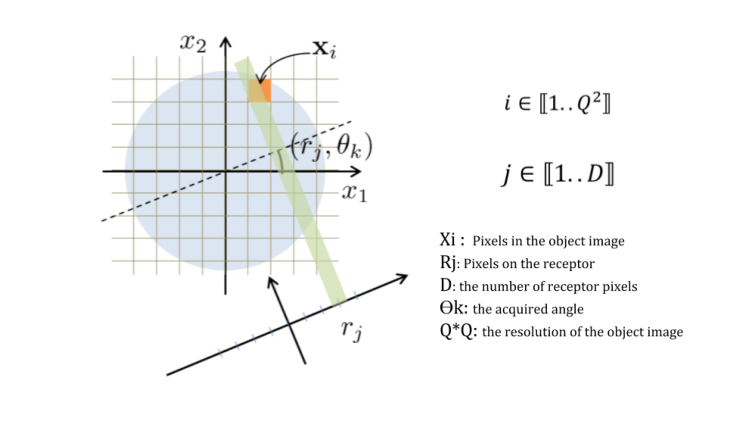

In [4]:
ill =  mpimg.imread("fig/tomo.png")
fig, ax= plt.subplots(figsize=(13,13))
myaximage = ax.imshow(ill)
ax.set_axis_off()
plt.show()

<font color='blue'>**Q: Considering a point object (i.e., only one nonzero pixel), what does the sinogram look like ? Complete the code below**</font>

<font color='red'>**A: See the plot**</font>

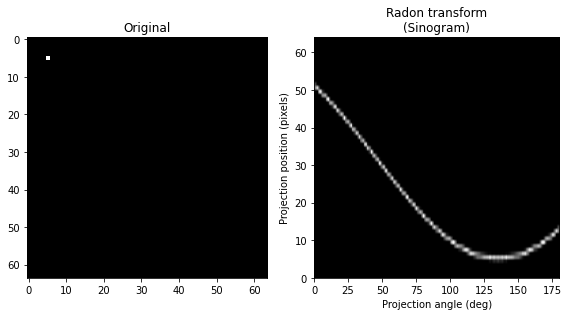

In [5]:
#Vector with acquired angles
theta = np.linspace(0., 180., 181)

#Creation of an object image with a single activated pixel
example = np.zeros((img_size, img_size)) #COMPLETE
example[5,5] = 1 # -----------------------DELETE HERE

#Simulation of scan via radon function
sinogram = radon(example, theta, circle=False)
sinogram = rescale(sinogram, scale=(pixel_size/sinogram.shape[0],1), mode='reflect', multichannel=False)

#Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))
ax1.set_title("Original")
ax1.imshow(example, cmap=plt.cm.Greys_r)

ax2.set_title("Radon transform\n(Sinogram)")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")
ax2.imshow(sinogram, cmap=plt.cm.Greys_r,
           extent=(0, 180, 0, sinogram.shape[0]), aspect='auto')

fig.tight_layout()
plt.show()

<font color='blue'>**Q: Explain the 'sinogram' terminology.**</font>

<font color='red'> **A:The sinogram terminology comes from the sine shape described by the sources.**</font>

## The radon operator
We aim at building a neural network to reconstruct an image given measurements $m$. For computational purpose, it can be interesting to consider the Radon transform as a matrix multiplication between a forward operator $A$ and the flattened true image $f$.

The corresponding matrix is illustrated below. In this example, each column accounts for the flattened sinogram computed for the corresponding pixel.

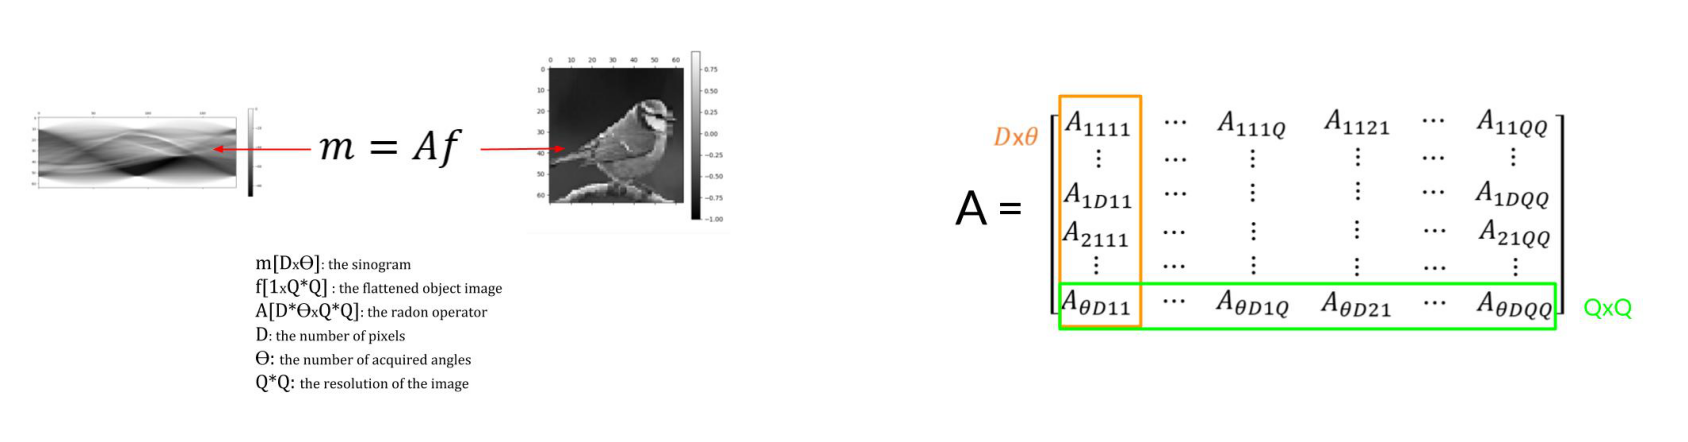

In [6]:
im1 =  mpimg.imread("fig/def var.jpg")
im2 =  mpimg.imread("fig/dim.jpg")
fig, (ax1, ax2)= plt.subplots(1, 2, figsize=(30,30))
ax1.imshow(im1)
ax2.imshow(im2)
ax1.set_axis_off()
ax2.set_axis_off()
plt.show()

### Creating the operator

Our objective here is to create this forward operator $A$ on a toy example for images of size $16\times 16$. 

<font color='blue'>**Based on the explanation above, complete the code below to create the matrix $A_{\text{example}}$**</font>.

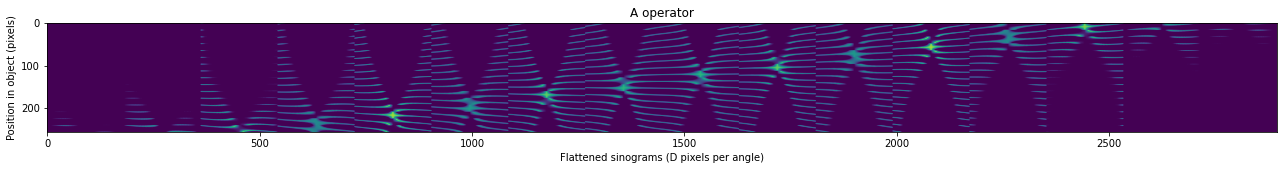

In [7]:
# Nb of angles of acquisition
total_angles = 181

# Define an empty matrix A
img_size_example = 16 #COMPLETE
pixel_size_example = 16 #COMPLETE
A_example = np.zeros((pixel_size_example*total_angles, img_size_example*img_size_example)) #COMLPLETE

# Fill the matrix 
for i in range(img_size_example):
    for j in range(img_size_example):
        # Activating a single pixel of the object image
        image = np.zeros((img_size_example,img_size_example)) ##COMPLETE
        image[i,j] = 1 ##COMLPETE
        
        # Radon transform
        sinogram = radon(image, theta, circle=False) ##COMPLETE
        sinogram = rescale(sinogram, scale=(pixel_size_example/sinogram.shape[0],1), mode='reflect', multichannel=False)
        ## COMPLETE above
        #Juxtaposing results in A matrix 
        A_example[:,pixel_size_example*i+j] = np.reshape(sinogram, (pixel_size_example*total_angles, )) ##COMLPETE

# A matrix visualisation
fig, ax = plt.subplots(figsize=(100, 2))
ax.imshow(np.transpose(A_example))
ax.set_title("A operator")
ax.set_xlabel("Flattened sinograms (D pixels per angle)")
ax.set_ylabel("Position in object (pixels)")
plt.show()

<font color='blue'> **Interpret the matrix** $\mathbf{A}$**. Especially, why is it sparse?**
</font>

<font color='red'> ** Each row corresponds to one pixel position in the image domain. Each column corresponds to a pixel detector at one angle position. The value at each position $(i,j)$ in the forward matrix corresponds to the contribution of the image pixel $i$ in the sinogram pixel $j$. The matrix is sparse because at a given angular position, only few pixels contribute to the value of one detector pixel. For instance when the detector is at angle 0, there are 16/256 pixels contributing for each detector pixel (1 out of 16 values of the image vector), that we can observe with the "lines" in the forward matrix.
**</font>

### Testing the resulting matrix

<font color='blue'>**Compute the code below to check that the created matrix matches the Radon transform. For this, compare sinograms obtained with the two operators.**</font>

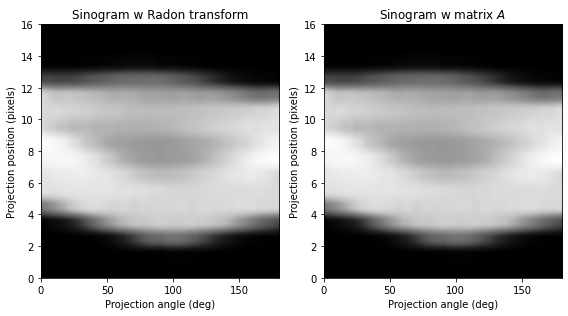

In [8]:
phantom = shepp_logan_phantom()
phantom = rescale(phantom, scale=(img_size_example/phantom.shape[0]), mode='reflect', multichannel=False)

# Radon transform with skimage function
radon1 = radon(phantom, theta, circle=False) ##COMPLETE
radon1 = rescale(radon1, scale=(pixel_size_example/radon1.shape[0], 1), mode='reflect', multichannel=False)
## COMPLETE ABOVE

# Radon transform with A matrix - Maybe do with numpy???
radon2 = torch.mv(torch.Tensor(A_example),torch.flatten(torch.tensor(phantom).float()))
radon2 = radon2.view(img_size_example, 181)

# Plots ##COMPLETE THE PLOT
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))
ax1.set_title("Sinogram w Radon transform")
ax1.set_xlabel("Projection angle (deg)")
ax1.set_ylabel("Projection position (pixels)")
ax1.imshow(radon1, cmap=plt.cm.Greys_r, extent=(0, 180, 0, radon1.shape[0]), aspect='auto')

ax2.set_title("Sinogram w matrix $A$")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")
ax2.imshow(radon2, cmap=plt.cm.Greys_r, extent=(0, 180, 0, radon2.shape[0]), aspect='auto')

fig.tight_layout()
plt.show()

### Inverse matrix
Now the aim is to retrieve $f$ from the measurements $m$, as it is the case in practice. A first idea could be to invert the matrix $A$. However the operator is not square and we will consider using the Moore-Penrose pseudo inverse.

The pseudo-inverse of a matrix $A$, denoted $A^\dagger$, is the matrix such that $\bar{x} = A^\dagger b$ if $\bar{x}$ is the solution of the least-squares minimization of the problem $Ax = b$.

<!-- It can be shown that if $Q_1 \Sigma Q_2^T = A$ is the singular value decomposition of A, then $A^\dagger = Q_2 \Sigma^+ Q_1^T$, where $Q_{1,2}$ are orthogonal matrices, $\Sigma$ is a diagonal matrix consisting of $A$’s so-called singular values (followed typically by zeros), and $\Sigma^\dagger$ is the diagonal matrix consisting of the reciprocals of $A$’s singular values (again, followed by zeros). [1]

[1] G. Strang, Linear Algebra and Its Applications, 2nd Ed., Orlando, FL, Academic Press, Inc., 1980, pp. 139-142. -->


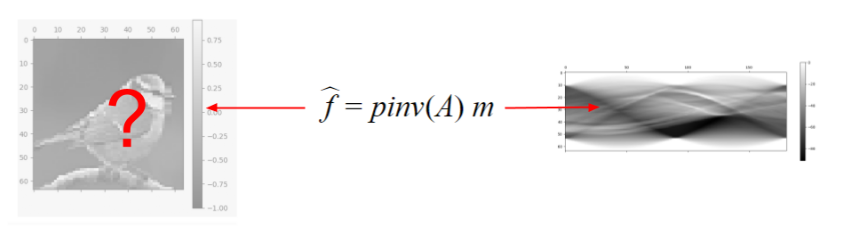

In [9]:
im =  mpimg.imread("fig/ill_pinv.png")
fig, ax= plt.subplots(figsize=(15,15))
myaximage = ax.imshow(im)
ax.set_axis_off()
plt.show()

Thus there are two ways to retrieve $f$ from $m$ : solve the least square minimization problem or directly compute the pseudoinverse and apply it on the measurement data.

<font color='blue'>**Thanks to scipy.linalg library, implement the two methods and compare the times of execution for both of them.**</font>

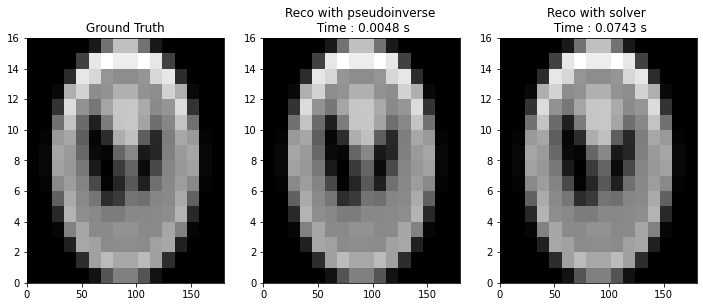

In [10]:
# Use the computed sinogram
sinogram = np.reshape(radon1, (-1, 1))

# Compute the pseudoinverse
pinv = lin.pinv(A_example)

# Rconstruct with pseudoinverse 
## COMPLETE BLOCK
t1 = time.perf_counter()
rec_pi = np.reshape(np.dot(pinv, sinogram), (img_size_example,img_size_example))
t1 = time.perf_counter() - t1

# Reconstruct with solver
## COMPLETE BLOCK
t2 = time.perf_counter()
rec_solv = np.reshape(lin.lstsq(A_example, sinogram)[0], (img_size_example,img_size_example))
t2 = time.perf_counter() - t2

# Display results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4.5))
ax1.set_title("Ground Truth")
ax1.imshow(phantom, cmap=plt.cm.Greys_r, extent=(0, 180, 0, phantom.shape[0]), aspect='auto')

ax2.set_title(f'Reco with pseudoinverse \n Time : {t1:.4f} s')
ax2.imshow(rec_pi, cmap=plt.cm.Greys_r, extent=(0, 180, 0, rec_pi.shape[0]), aspect='auto')

ax3.set_title(f'Reco with solver \n Time : {t2:.4f} s')
ax3.imshow(rec_solv, cmap=plt.cm.Greys_r, extent=(0, 180, 0, rec_solv.shape[0]), aspect='auto')

<font color='blue'>**Which method is faster? According to you, what are the limits of this method of reconstruction?**</font>


<font color='red'>**A: reconstruction with pseudoinverse is faster than with the solver. Limits include: dealing with huge matrices in the case of larger images (pb of memory and time), cases where there are less acquisition angles, problem of noise,...**</font>

# 2 - Compressed Acquisition

Now we have the forward matrix $A$ and we are able to compute the pseudo inverse to solve the backprojection problem. However, in reality, we might not have measurements/projections acquired with a step size of 1 degree. 

We are now going to investigate the behaviour of the pseudoinverse based reconstruction method when the number of projection decreases.

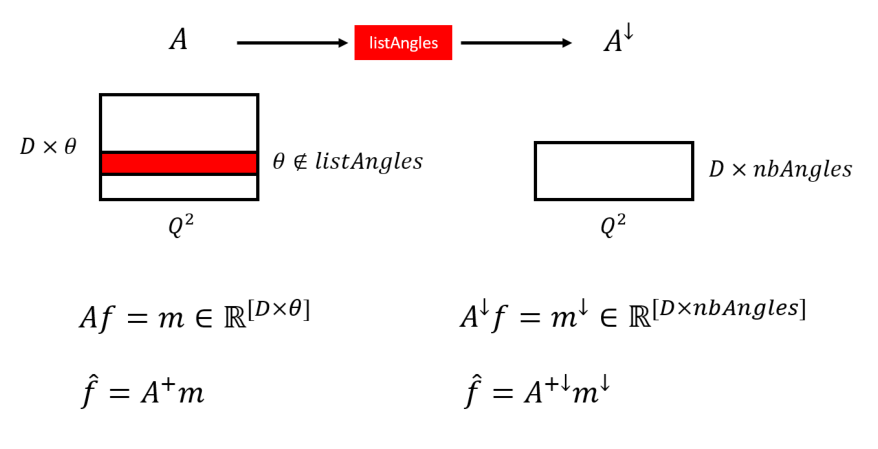

In [11]:
im1 =  mpimg.imread("fig/Explain_a_reduced.PNG")
plt.figure(figsize=(30,8))
plt.imshow(im1)
plt.axis('off')
plt.show()

As we are going to work now with images of size $64 \times 64$, forward matrix and the corresponding pseudoinverse were pre-computed for the full angle data. We will consider a case where the acquisition was performed with less projection data (20 angles).

<font color='blue'>Load the pre-computed matrices. Compute $A_{\text{reduced}}$ obtained by removing angles so that projections are obtained for only 20 angles. Compute the pseudoinverse of the reduced forward matrix.</font>
<font color='blue'>- Check the Dimensions of $\mathbf{A}_\text{reduced}$. Is it what you expected?</font>

<font color='red'>**A: Areduced should be of size (64x64, 20x64)**</font>

In [12]:
# Data path
data_root = '/floyd/input/dlmis21_reconstruction_hands_on_vf/'
saved_data = data_root + 'matrices/'

# Load forward matrix with full angle data
radon_matrix_path = saved_data + 'Q{}_D{}.mat'.format(img_size, pixel_size)
H = sio.loadmat(radon_matrix_path)
A = H.get("A")
A = np.array(A)
A = torch.from_numpy(A)
A = A.type(torch.FloatTensor)

# Load the corresponding pseudoinverse
pinv_matrix_path = saved_data + 'pinv_Q{}_D{}.mat'.format(img_size, pixel_size)
H = h5.File(pinv_matrix_path, 'r')
pinvA = H.get("A_pinv")
pinvA = np.array(pinvA)
pinvA = np.transpose(pinvA)
pinvA = torch.from_numpy(pinvA)
pinvA = pinvA.type(torch.FloatTensor)

# Compute the reduced forward matrix
nbAngles = 20 ##COMPLETE THIS LINE ONLY
Areduced = model_radon.radonSpecifyAngles(A, model_radon.generateAngles(nbAngles))
Areduced = Areduced.type(torch.FloatTensor)

# Compute the corresponding pseudoinverse
## COMPLETE THE BLOCK
if device == "cuda:0":
    pinvAreduced = lin.pinv(Areduced.cpu().numpy())
else:
    pinvAreduced = lin.pinv(Areduced.numpy())
    
pinvAreduced = torch.from_numpy(pinvAreduced)
pinvAreduced = pinvAreduced.type(torch.FloatTensor)

Now that forward matrices and their pseudo inverse have been loaded/computed, we will study the quality of the corresponding reconstructions on some toy image.

<font color='blue'>Complete the code below to </font>
- <font color='blue'> Compute the sinograms with both forward operators</font>
- <font color='blue'>Reconstruct the image with the corresponding pseudoinverse. </font>

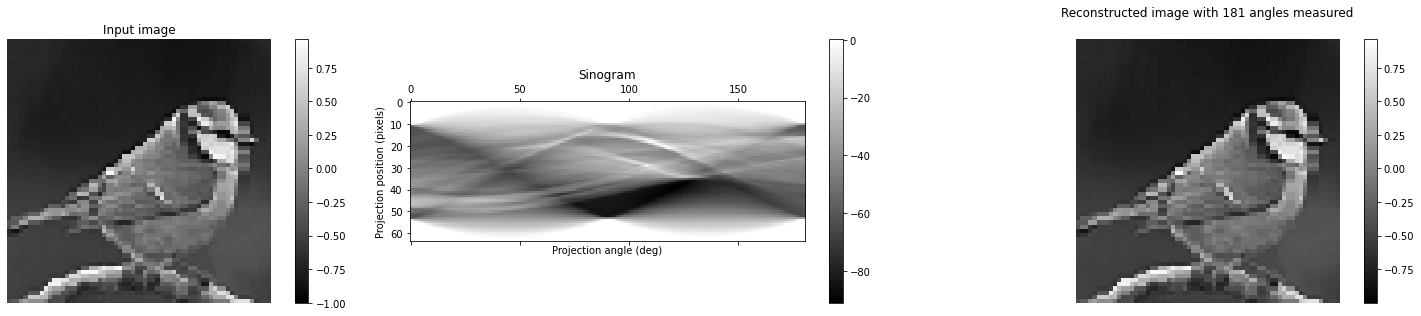

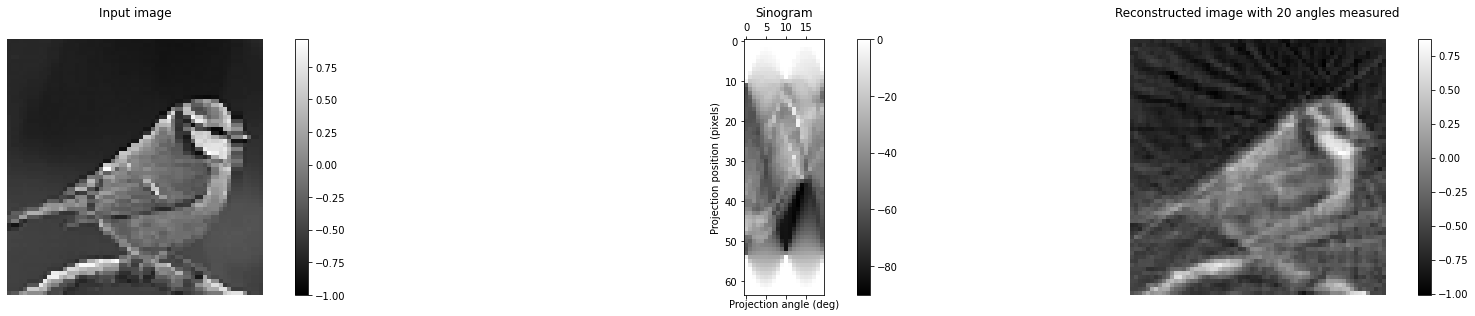

In [13]:
# Load the image
im = Image.open("fig/image.png")
im = ImageOps.grayscale(im)

# Preprocess the image
im_array = np.asarray(im)
im_array = im_array.astype(np.float32)
im_array = 2*(im_array)/255 - np.ones([64,64])

# Pass it as a torch object
f = torch.from_numpy(im_array)
f = f.view(1,img_size**2);
f = f.t()
f = f.type(torch.FloatTensor)

# Simulate the measurements with full angle and limited angle configurations
m_reduced = torch.mv(Areduced,f[:,0]) ##COMPLETE
m_perfect = torch.mv(A,f[:,0]) ##COMPLETE

# Reconstruct in the case of full angle data
f_perfect = torch.mv(pinvA, m_perfect) ##COMPLETE #should be a 1D vector here
# Resize to a 2D shape
f_perfect_array = model_radon.vector2matrix(f_perfect, [img_size,img_size])
f_perfect_array = np.transpose(f_perfect_array)

# Reconstruct in the case of limited angle data
f_reconstruct = torch.mv(pinvAreduced ,m_reduced) ##COMPLETE
# Resize to a 2D shape
f_reconstruct_array = model_radon.vector2matrix(f_reconstruct, [img_size,img_size])
f_reconstruct_array = np.transpose(f_reconstruct_array)

# Display results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 4.5))

ax1.set_title("Input image")
pcm1 = ax1.imshow(im_array, cmap='gray')
ax1.set_axis_off()

ax2.set_title("Sinogram")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")
m_perfect_array = model_radon.vector2matrix(m_perfect, [total_angles,pixel_size])
pcm2 = ax2.matshow(m_perfect_array, cmap='gray')

ax3.set_title("Reconstructed image with 181 angles measured")
pcm3 = ax3.matshow(f_perfect_array, cmap='gray')
ax3.set_axis_off()

fig.colorbar(pcm1,ax=ax1)
fig.colorbar(pcm2,ax=ax2)
fig.colorbar(pcm3,ax=ax3)
fig.tight_layout()

fig2, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 4.5))

ax1.set_title("Input image")
pcm1 = ax1.matshow(im_array, cmap='gray')
ax1.set_axis_off()

ax2.set_title("Sinogram")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")
m_array = model_radon.vector2matrix(m_reduced, [nbAngles,pixel_size])
pcm2 = ax2.matshow(m_array, cmap='gray')

ax3.set_title("Reconstructed image with 20 angles measured")
pcm3 = ax3.matshow(f_reconstruct_array, cmap='gray')
ax3.set_axis_off()

fig2.colorbar(pcm1,ax=ax1)
fig2.colorbar(pcm2,ax=ax2)
fig2.colorbar(pcm3,ax=ax3)
fig2.tight_layout()

plt.show()

<font color='blue'>**Interpret the results. Is the pseudoinverse based reconstruction method still satisfying with 20 measurement angles?**</font>

<font color='red'>**A: Visible artefacts, loss of details...**</font>

## Reconstructed images for multiple numbers of acquisition angles

We have seen the degradation of the image when reducing the number of measurement angles. To further study this degradation process, we will now repeat the steps for different numbers of projection angles.

<font color='blue'> For the different number of angles shown in ```listAngles```, perform </font>
- <font color='blue'>The $A_{\text{reduced}}$ and its pseudoinverse computation</font>
- <font color='blue'>The simulation of the measurement data</font>
- <font color='blue'>The image reconstruction </font>

For computational reasons, results with 100, 140 and 180 angles were pre-computed and can be compared with the obtained reconstructions.

Computation is on going, it might take up to 1 minute...


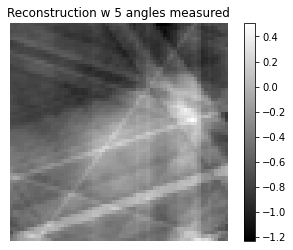

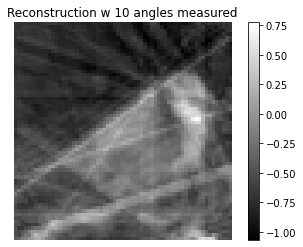

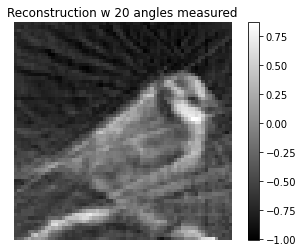

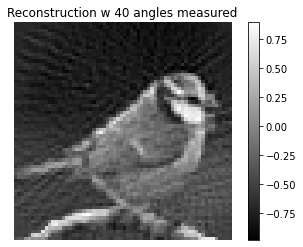

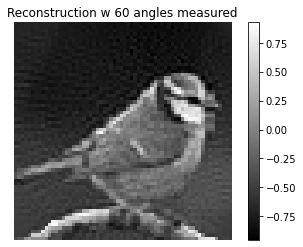

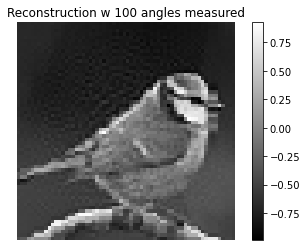

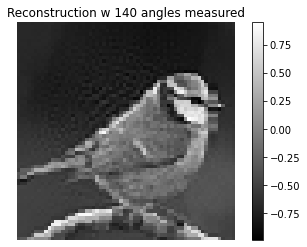

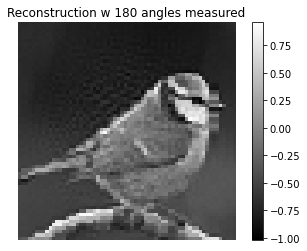

In [14]:
listAngles = [5, 10, 20, 40, 60]

print('Computation is on going, it might take up to 1 minute...')
##PERFORM THE WHOLE LOOP
for ang in listAngles:
    # Compute Areduced
    Areduced = model_radon.radonSpecifyAngles(A, model_radon.generateAngles(ang))
    Areduced = Areduced.type(torch.FloatTensor)
    
    # Compute the pseudoinverse
    if device == "cuda:0":
        pinvAreduced = lin.pinv(Areduced.cpu().numpy())
    else:
        pinvAreduced = lin.pinv(Areduced.numpy())
    pinvAreduced = torch.from_numpy(pinvAreduced)
    pinvAreduced = pinvAreduced.type(torch.FloatTensor)
    
    # Simulate the measurements
    m = torch.mv(Areduced,f[:,0])
    
    # Reconstruct the image
    f_reconstruct = torch.mv(pinvAreduced,m)
    
    # Reshape into a 2D mage
    f_reconstruct_array = model_radon.vector2matrix(f_reconstruct, [img_size,img_size])
    f_reconstruct_array = np.transpose(f_reconstruct_array)
    
    # Display results
    plt.imshow(f_reconstruct_array, cmap='gray')
    plt.title(f'Reconstruction w {ang} angles measured')
    plt.colorbar()
    plt.axis('off')
    plt.show()
    
# Display the pre-computed reconstructions
supp_angles = [100, 140, 180]
path_rec = data_root + 'reconstructed/'
for ang in supp_angles:
    f_reconstruct_array = np.load(path_rec + f'reconstructed_{ang}_angles.npy')
    plt.imshow(f_reconstruct_array, cmap='gray')
    plt.title("Reconstruction w {} angles measured".format(ang))
    plt.colorbar()
    plt.axis('off')
    plt.show()

<font color='blue'> According to you, what is the minimum number of measurement angles that allows to use the pseudoinverse as a satisfying reconstruction method? </font>

<font color='red'>**A: 60 starts to be OK**</font>

# 3 - Statistical completion

## Problem of pseudo-inverse

Compute new formula of pseudo-inverse


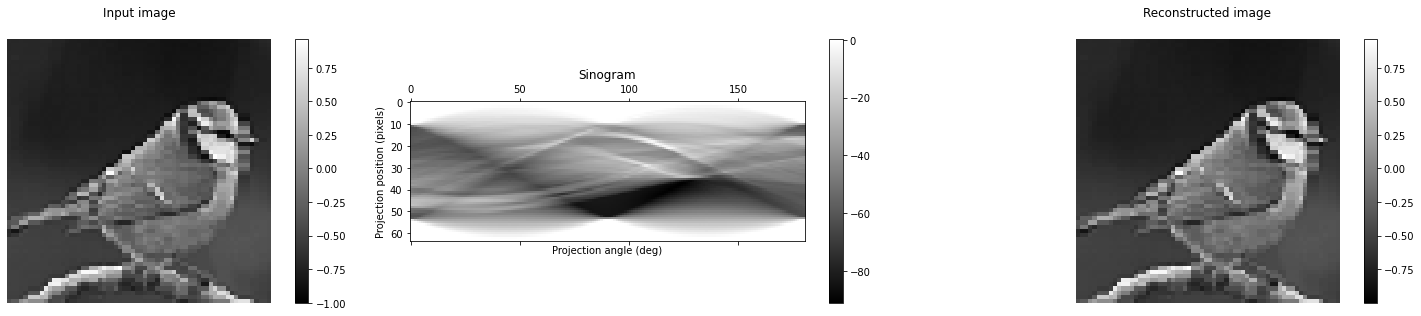

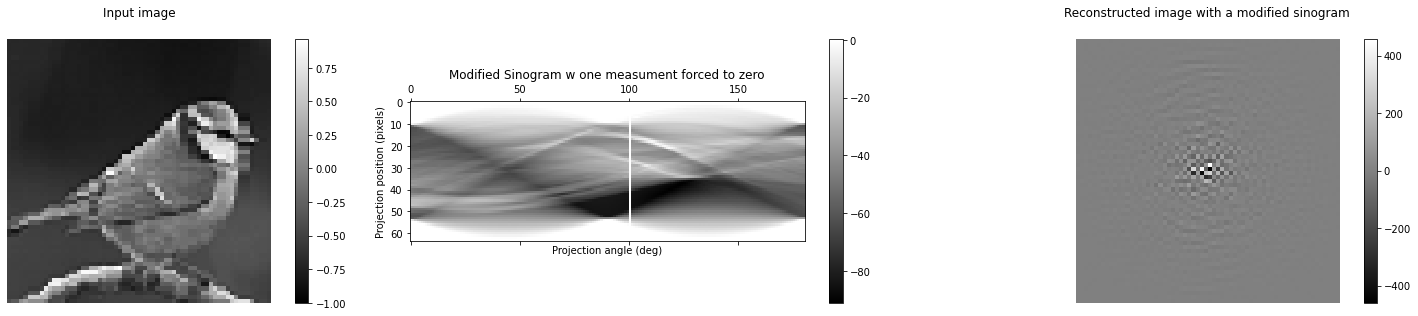

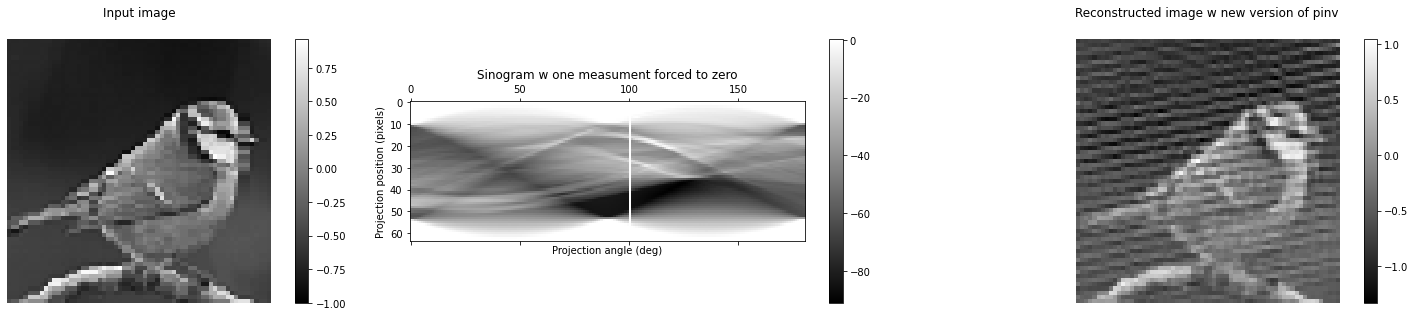

In [15]:
# Afficher le sinograme modifié
m_modified = m_perfect.clone().detach()
m_modified[6400:6464] = 0 

m_modified_array = model_radon.vector2matrix(m_modified, [181,64])

#Reconstruire avec A
f_reconstruct2 = torch.mv(pinvA,m_modified)
f_reconstruct2_array = model_radon.vector2matrix(f_reconstruct2, [64,64])
f_reconstruct2_array = np.transpose(f_reconstruct2_array)

print('Compute new formula of pseudo-inverse')
regu = 1e1
if device == "cuda:0":
    pinvA2 = np.dot(lin.inv(np.dot(np.transpose(A.cpu().numpy()),A.cpu().numpy())+regu*np.eye(64*64)),np.transpose(A.cpu().numpy()))
else:
    pinvA2 = np.dot(lin.inv(np.dot(np.transpose(A.numpy()),A.numpy())+regu*np.eye(64*64)),np.transpose(A.numpy()))
pinvA2 = torch.from_numpy(pinvA2)
pinvA2 = pinvA2.type(torch.FloatTensor)

#Reconstruire avec A avec la nouvelle pinv
f_reconstruct3 = torch.mv(pinvA2,m_modified)
f_reconstruct3_array = model_radon.vector2matrix(f_reconstruct3, [64,64])
f_reconstruct3_array = np.transpose(f_reconstruct3_array)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 4.5))

ax1.set_title("Input image")
pcm1 = ax1.matshow(im_array, cmap='gray')
ax1.set_axis_off()

ax2.set_title("Sinogram")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")
pcm2 = ax2.matshow(m_perfect_array, cmap='gray')

ax3.set_title("Reconstructed image")
pcm3 = ax3.matshow(f_perfect_array, cmap='gray')
ax3.set_axis_off()

fig.colorbar(pcm1,ax=ax1)
fig.colorbar(pcm2,ax=ax2)
fig.colorbar(pcm3,ax=ax3)
fig.tight_layout()

fig2, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 4.5))

ax1.set_title("Input image")
pcm1 = ax1.matshow(im_array, cmap='gray')
ax1.set_axis_off()

ax2.set_title("Modified Sinogram w one measument forced to zero")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")
pcm2 = ax2.matshow(m_modified_array, cmap='gray')

ax3.set_title("Reconstructed image with a modified sinogram")
pcm3 = ax3.matshow(f_reconstruct2_array, cmap='gray')
ax3.set_axis_off()

fig2.colorbar(pcm1,ax=ax1)
fig2.colorbar(pcm2,ax=ax2)
fig2.colorbar(pcm3,ax=ax3)
fig2.tight_layout()

fig3, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 4.5))

ax1.set_title("Input image")
pcm1 = ax1.matshow(im_array, cmap='gray')
ax1.set_axis_off()

ax2.set_title("Sinogram w one measument forced to zero")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")
pcm2 = ax2.matshow(m_modified_array, cmap='gray')

ax3.set_title("Reconstructed image w new version of pinv")
pcm3 = ax3.matshow(f_reconstruct3_array, cmap='gray')
ax3.set_axis_off()

fig3.colorbar(pcm1,ax=ax1)
fig3.colorbar(pcm2,ax=ax2)
fig3.colorbar(pcm3,ax=ax3)
fig3.tight_layout()

plt.show()

We can see on those figures that the backprojection matrix seems to be ill-conditioned for small variations in the sinogram. For example, if we force a column of the sinogram to zero, the reconstructed image ins't good at all. If we see changing pixels values of the sinogram as adding noise to it, an other method of computing the pseudo-inverse matrix could solve this issue introducing a regularisation parameter. 

The next step consist of filling sinogram's missing values using statistical completion and compare the reconstruction with previous method.

## Statistical completion

The idea of statistical completion is to give a value for missing data depending on statistics from a dataset. In the example below taken from [1] we can see that the value of a certain pixel in the image is correlated with the values of other pixels (here between coefficient 7 and 2).

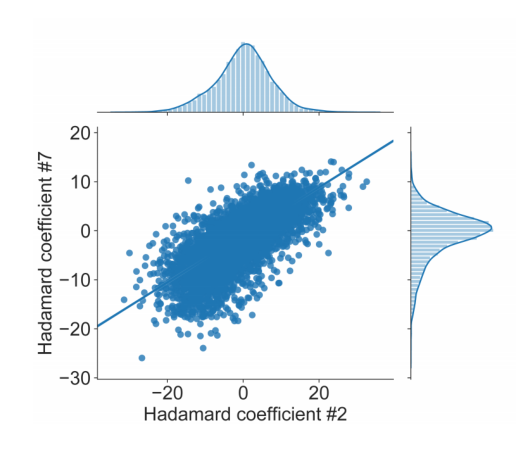

In [16]:
im1 =  mpimg.imread("fig/Hadamard_coeff.PNG")
plt.figure(figsize=(30,8))
plt.imshow(im1)
plt.axis('off')
plt.show()

##  Mean and covariance

Instead of computing a new pseudo-inverse matrix from the reduced forward radon matrix A, we can se the problem as a full sinogram with missing measurement. Statistical completion of those missing data show promising result in [1] We can use the STL-10 image library to determine statistical information in order to improve low angle resolution measurements.

[1] 2020 IEEE 17th International Symposium on Biomedical Imaging (ISBI), Apr 2020, Iowa City, United States. pp.619-623.
⟨10.1109/ISBI45749.2020.9098390⟩
[hal-02342766v2](https://hal.archives-ouvertes.fr/hal-02342766v2/document)


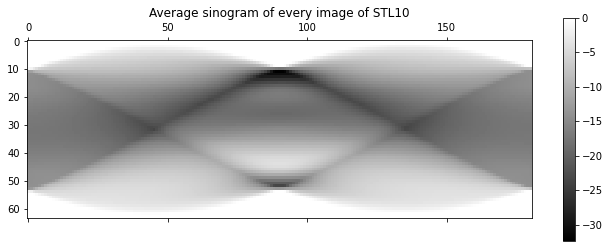

In [17]:
#Import mean and covariance matrix
Mean_radon = torch.load(saved_data+'Mean_Q64D64.pt', map_location='cpu')
Cov_radon = torch.load(saved_data+'Cov_Q64D64.pt', map_location='cpu')
#Mean_radon = torch.load('Mean_Q64D64.pt', map_location='cpu')
#Cov_radon = torch.load('Cov_Q64D64.pt', map_location='cpu')

Mean_radon_array = model_radon.vector2matrix(Mean_radon, [181,64])

plt.matshow(Mean_radon_array, cmap='gray')
plt.title("Average sinogram of every image of STL10")
plt.colorbar()
plt.show()

## Statistical completion for consecutive measurement angles

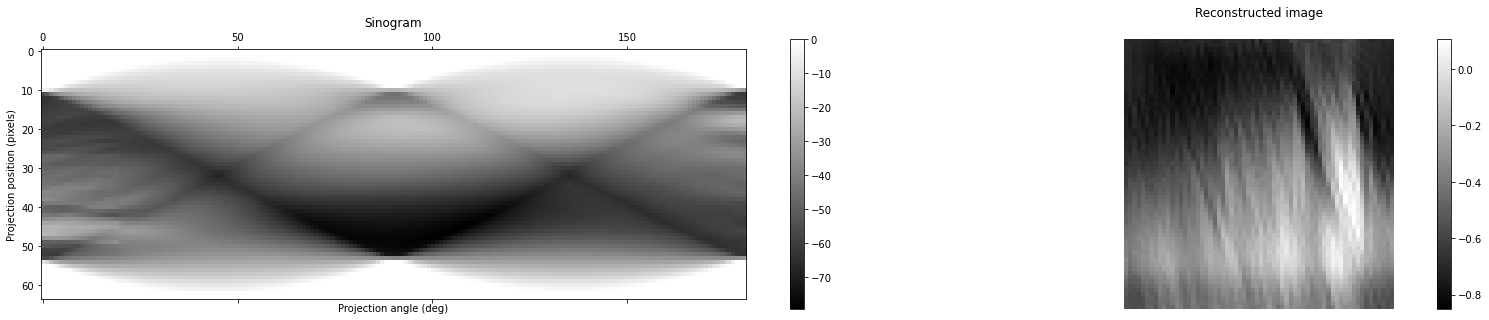

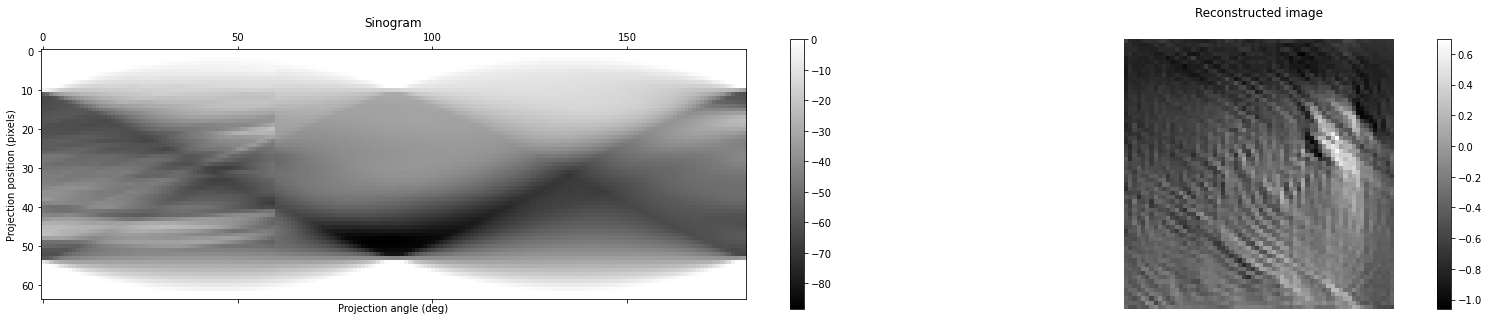

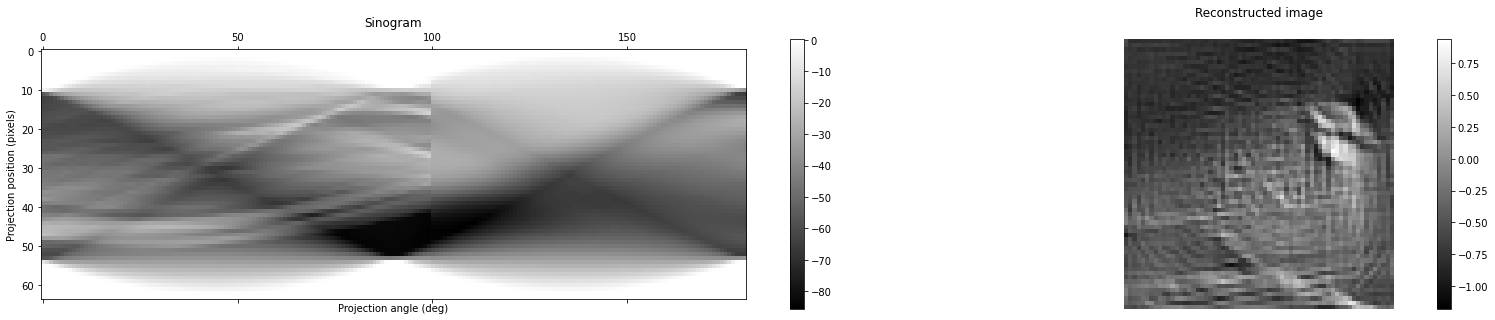

In [18]:
nbReconstruct = 3
listAngles = np.array([20, 60, 100, 150])

for i in range(0,nbReconstruct):
   
    #Tronquer le sinogramme après un certain nombre d'angles d'acquisition
    m_reduced = m_perfect[:listAngles[i]*64]

    #Séparation des moyennes des pixels. mu1 étant l'acquisition et mu2 les pixel à boucher
    mu1 = Mean_radon[:listAngles[i]*64,0]
    mu2 = Mean_radon[listAngles[i]*64:,0]

    #Séparation des covariances des pixels. Simga1 covariance de l'acquisition, Sigma21 la covariance des pixels acquis et non acquis
    Sigma1 = Cov_radon[:64*listAngles[i],:64*listAngles[i]]
    Sigma21 = Cov_radon[64*listAngles[i]:,:64*listAngles[i]]

    #Complétion statistique
    diff = m_reduced-mu1

    sigma1_np = Sigma1.numpy()

    pinvs = lin.pinv(sigma1_np)

    pinvSigma1 = torch.from_numpy(pinvs)

    sMix = torch.matmul(Sigma21,pinvSigma1)

    y2 = mu2 + torch.mv(torch.matmul(Sigma21,pinvSigma1),diff)

    B = torch.mv(sMix,m_reduced)
    B_np = B.numpy()
    W = mu2 - torch.mv(sMix,mu1)
    W_np = W.numpy()
    
    m_complete = torch.zeros(64*181)
    m_complete[:64*listAngles[i]] = m_reduced
    m_complete[64*listAngles[i]:] = y2

    m_complete_array = model_radon.vector2matrix(m_complete, [181,64])    

    f_filled = torch.mv(pinvA2,m_complete)

    f_filled_array = model_radon.vector2matrix(f_filled, [64,64])
    f_filled_array = np.transpose(f_filled_array)    
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 4.5))

    ax1.set_title("Sinogram")
    ax1.set_xlabel("Projection angle (deg)")
    ax1.set_ylabel("Projection position (pixels)")
    pcm1 = ax1.matshow(m_complete_array, cmap='gray')

    ax2.set_title("Reconstructed image")
    pcm2 = ax2.matshow(f_filled_array, cmap='gray')
    ax2.set_axis_off()
    
    fig.colorbar(pcm1,ax=ax1)
    fig.colorbar(pcm2,ax=ax2)
    fig.tight_layout()
    plt.show()

The simplest statistical completion algorithm separate the acquired and not acquired data with a treshold. We can observe that the completed sinogram looks great. Nevertheless the reconstruction is not ideal because most of the measurements are with acquisition angles which are close to each other. A smarter idea would be to complete multiple holes in the sinogram while spacing acquisition angles.

## Statistical completion for linear spaced measurement angles

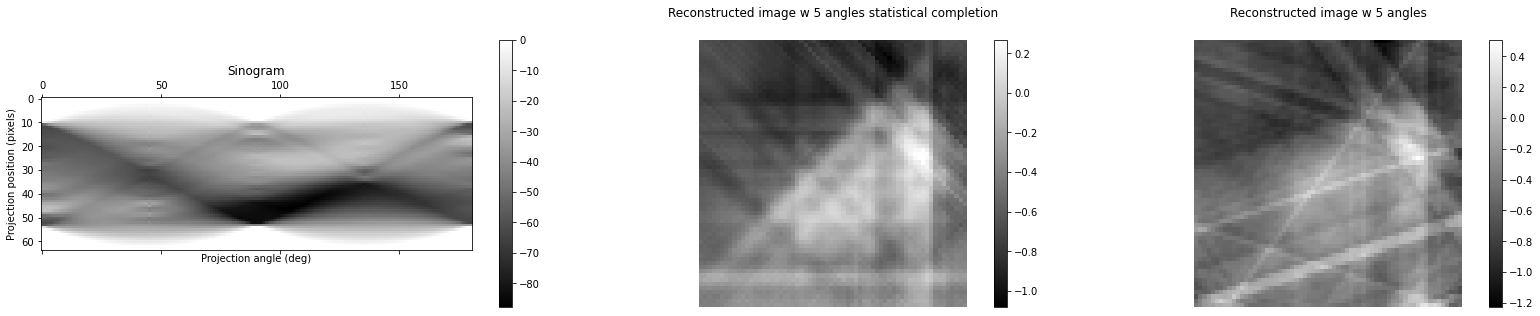

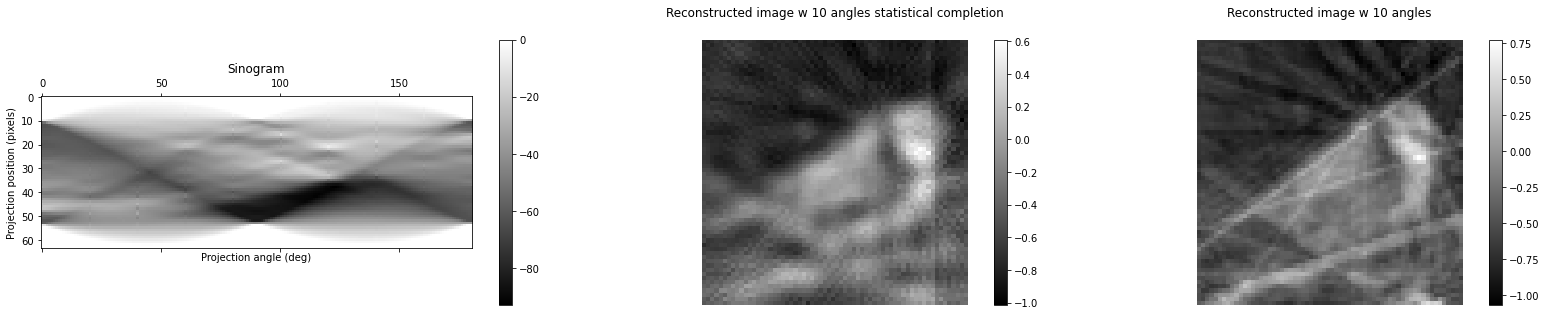

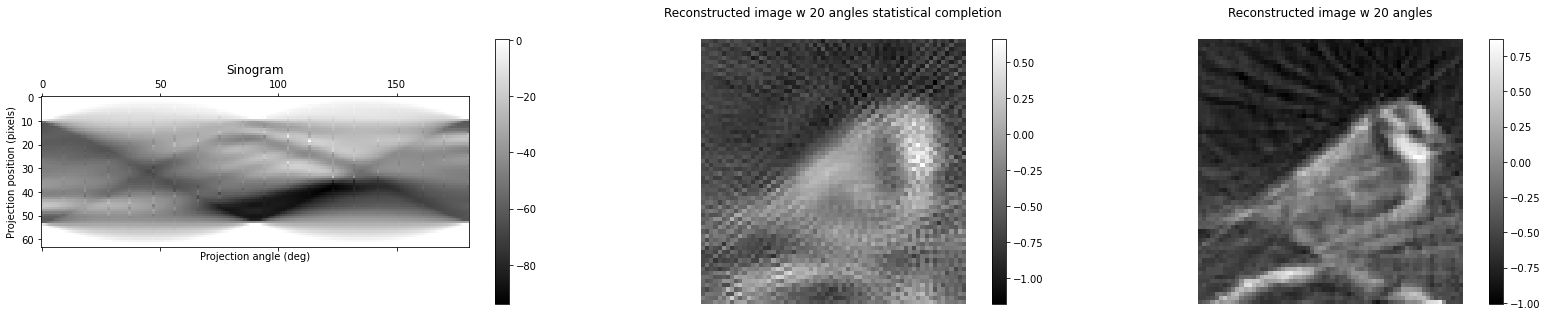

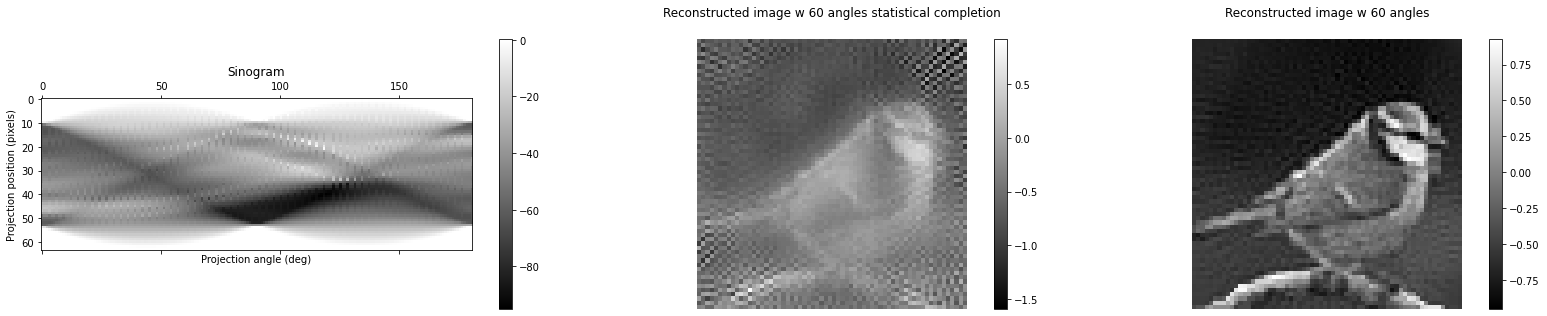

In [19]:
nbReconstruct = 4
listAngles = np.array([5, 10, 20, 60])

mu = Mean_radon.numpy()
sigma = Cov_radon.numpy()

for i in range(0,nbReconstruct):
    
    #Create holes
    angles = model_radon.generateActivationAngles(listAngles[i])
    m_perfect_holes = torch.zeros(listAngles[i]*64)
    m_unperfect = torch.zeros(181*64)
    count = 0
    for j in range(0,181):
        if (angles[j] == 1):
            m_perfect_holes[count*64:count*64+64] = m_perfect[j*64:j*64+64]
            m_unperfect[j * 64:j * 64 + 64] =m_perfect[j*64:j*64+64]
            count = count + 1   
            
    #Statistical completion
    muTuple = model_radon.separateMu(mu,angles,listAngles[i])
    sigmaTuple = model_radon.separateSigma(sigma,angles,listAngles[i])
    networkTuple = model_radon.computeUnknownData(muTuple[0], muTuple[1], sigmaTuple[0], sigmaTuple[1],angles,listAngles[i])

    W = torch.from_numpy(networkTuple[0])
    W = W.type(torch.FloatTensor)
    B = torch.from_numpy(networkTuple[1])
    B = B.type(torch.FloatTensor)

    m_filled_bias = torch.mv(W,m_perfect_holes) + B

    #afficher le sinogrames bouché avec Biais
    m_filled_bias_array = model_radon.vector2matrix(m_filled_bias, [181,64])

    #reconstruire l'image
    f_reconstructed = torch.mv(pinvA2,m_filled_bias)
    f_reconstructed_array = model_radon.vector2matrix(f_reconstructed, [64,64])
    f_reconstructed_array = np.transpose(f_reconstructed_array)

    Areduced = model_radon.radonSpecifyAngles(A, model_radon.generateAngles(listAngles[i]))
    Areduced = Areduced.type(torch.FloatTensor)
    if device == "cuda:0":
        pinvAreduced = lin.pinv(Areduced.cpu().numpy())
    else:
        pinvAreduced = lin.pinv(Areduced.numpy())
    pinvAreduced = torch.from_numpy(pinvAreduced)
    pinvAreduced = pinvAreduced.type(torch.FloatTensor)
    f_poor = torch.mv(pinvAreduced,torch.mv(Areduced,f[:,0]))
    f_poor_array = model_radon.vector2matrix(f_poor, [64,64])
    f_poor_array = np.transpose(f_poor_array)    

    #Afficher les résultats
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 4.5))

    ax1.set_title("Sinogram")
    ax1.set_xlabel("Projection angle (deg)")
    ax1.set_ylabel("Projection position (pixels)")
    pcm1 = ax1.matshow(m_filled_bias_array, cmap='gray')

    ax2.set_title("Reconstructed image w {} angles statistical completion".format(listAngles[i]))
    pcm2 = ax2.matshow(f_reconstructed_array, cmap='gray')
    ax2.set_axis_off()

    ax3.set_title("Reconstructed image w {} angles".format(listAngles[i]))
    pcm3 = ax3.matshow(f_poor_array, cmap='gray')
    ax3.set_axis_off()    
    
    fig.colorbar(pcm1,ax=ax1)
    fig.colorbar(pcm2,ax=ax2)
    fig.colorbar(pcm3,ax=ax3)
    fig.tight_layout()
    plt.show()
    
    plt.show()

Unfortunately, we can observe a sort of noise apearing with the increase in number of measured angles. This might come from the value of the regularisation parameter for the pseudo inverse used for reconstruction with statistical completion.

# 4 - Deep-learning Image reconstruction

Image reconstruction via deep neural netoworks aims to find an analytical non-linear mapping $\mathcal{G}^*$ such that 

\begin{equation*}
\mathcal{G}^*(\mathbf{m}) \approx \mathbf{f}.
\label{eq:mapping} \tag{1}
\end{equation*}

In order to achieve such purpose, we consider a neural network $\mathcal{G}_\Omega$ with parameters $\Omega$.
The weights are then chosen to maximise the cost function :

\begin{equation*}
\Omega^* = \underset{\mathbf{f}}{\text{argmax}} \sum_{i=0}^{S-1} \| \mathcal{G}_\Omega(\mathbf{m}_i) - \mathbf{f}_i\|^2_1 + \mathcal{R}(\Omega)
\label{eq:fn} \tag{2}
\end{equation*}
Where $(\mathbf{m}_i , \mathbf{f}_i)_{i\in \{0, \dots S-1\}}$ are the samples of a supervised image dataset. $\mathcal{R}$ is a regularisation function with the purpose of stabilizing the training of the neural network.
The choice of $\mathcal{R}$ may have a big impact on the resulting reconstructor. Amongst the most common choices of $\mathcal{R}$, we can have $\mathcal{R}(.) = \|.\|^2_2$ or $\mathcal{R}(.) = \|.\|_1$ for instance.

For this study we will consider $\mathcal{R}(.) = \alpha \|.\|^2_2$, where $\alpha$ is a positive constant that will impact how important $\mathcal{R}$ is with respect to the rest of the cost function.

As convolutional layers have proven to be particularly successful in dealing with images, we like to map the measured sinogram $\mathbf{m}$ into the image domain to get $\tilde{\mathbf{f}}$, a raw linear estimation of $\mathbf{f}$. 

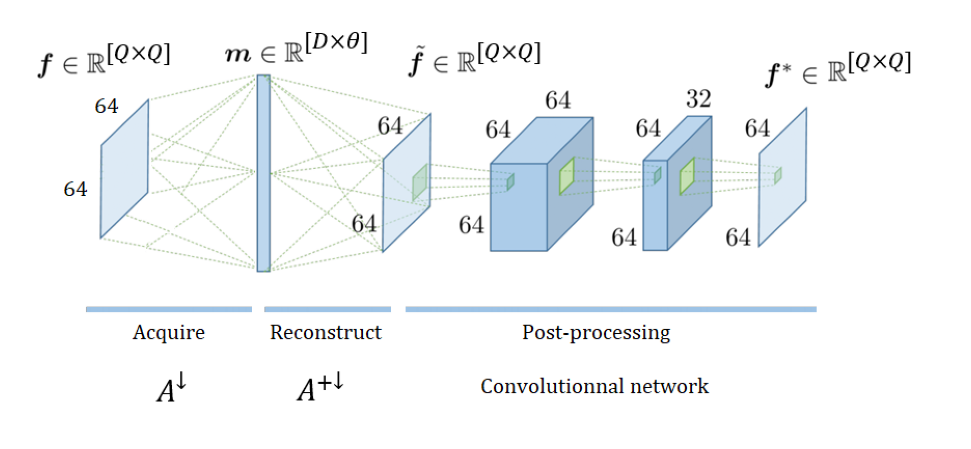

In [20]:
im1 =  mpimg.imread("fig/network.png")
plt.figure(figsize=(30,8))
plt.imshow(im1)
plt.axis('off')
plt.show()

<font color='blue'>**Q: Explain why we chose to map the sinogram in the image domain via the Moore-Penrose pseudo-inverse rather than learning a mapping from scratch alongside with the rest of the convolutional reconstructor.**</font>

<font color='red'>**A: The answer is two-fold. The first answer is that we know that convolutional layers have shown great success in exploiting spacial redundancies of natural images, so we would like to apply the neural network on the image domain. Do note however that several studies have also shown that convolutional layers can be used on sinograms, and to great success. So it's not a compulsorey projection, but a choice. The second part of the answer is that we needed a mapping from the synogram to the image domain. While we could learn everything, we would end up with a lot of parameters to learn : a linear reconstructor would have $D\times \theta \times, Q^2$ parameters.**</font>

In [21]:
from spyrit.learning.model_Had_DCAN import Weight_Decay_Loss
from spyrit.learning.nets import train_model


net_types = ['c0mp', 'comp','pinv', 'free']
net_arch = 2
regularisation = 1e-7

num_epochs=3
batch_size=256
reg=1e-7
lr=1e-3
step_size=20
gamma=0.2
checkpoint_model=""
checkpoint_interval=0
model_root='./models/'

## Importing the dataset

In [22]:
transform = transforms.Compose(
    [transforms.functional.to_grayscale,
     transforms.Resize((img_size, img_size)),
     transforms.ToTensor(),
     transforms.Normalize([0.5], [0.5])])

trainset = torchvision.datasets.ImageFolder(root=data_root+"train", transform=transform)
trainloader = \
    torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=False)

testset = torchvision.datasets.ImageFolder(root=data_root+"test", transform=transform)
testloader = \
    torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False)

dataloaders = {'train': trainloader, 'val': testloader}
inputs, labels = next(iter(dataloaders['val']))
inputs = inputs.to(device)

print(im_array.shape)

im_tensor = torch.from_numpy(im_array)
m = torch.mv(Areduced,f[:,0])
test_batch = 1
color = 0
# inputs[0, 0, :, :] = im_tensor


(64, 64)


<font color='blue'>**Q: What is the shape of every sample of the dataset? Explain what every dimension corresponds to?**</font>

<font color='red'>**A: \[Batch_size, channels, height, width\]**</font>

<font color='blue'>**Q: Why is it important to normalize all the data from the original dataset?**</font>

<font color='red'>**A: Normallized data (in particular 0 mean data) helps stabilizing the training of the Deep neural network. It's also important when the raw data has several orders of magnitude to ensure that your neural networks gets a well defined operating range. As a non-linear reconstructor, it might not work as well if the data has several orders of magnitude.**</font>

## Training a neural network reconstructor from scratch for 3 epochs

<font color='blue'>**Q: Complete the code : compute Areduced and pinvAreduced as the forward operator and the pseudo-inverse for 20 projections.**</font>


<font color='red'>**A: They've already done it in the previous sections, so they should know how to do it. But I also want them to understand that the Pinv is directly used in the deep-neural reconstructor.**</font>

In [23]:
test_amt = 4
nbAngles = 20

###################  TO BE COMPLETED
Areduced = model_radon.radonSpecifyAngles(A, model_radon.generateAngles(nbAngles))
Areduced = Areduced.type(torch.FloatTensor)
if device == "cuda:0":
    pinvAreduced = lin.pinv(Areduced.cpu().numpy())
else:
    pinvAreduced = lin.pinv(Areduced.numpy())
pinvAreduced = torch.from_numpy(pinvAreduced)
pinvAreduced = pinvAreduced.type(torch.FloatTensor)
####################################

model = model_radon.compNet(img_size, pixel_size, nbAngles, A = Areduced, pinvA = pinvAreduced, variant=net_arch)
model = model.to(device)


loss = nn.MSELoss();
criterion = Weight_Decay_Loss(loss);
optimizer = optim.Adam(model.parameters(), lr=lr);
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

model, train_info = train_model(model, criterion, \
        optimizer, scheduler, dataloaders, device, model_root, num_epochs=num_epochs,\
        disp=True, do_checkpoint=checkpoint_interval)

Measurement to image domain: pseudo inverse
[train] [Epoch 1/3] [Batch 80/80] [Loss: 0.017728] ETA: 0:00:55.191821
train Loss: 21.2071 
[val] [Epoch 1/3] [Batch 4/4] [Loss: 0.059286] ETA: 0:00:02.478597
val Loss: 14.1656 
[train] [Epoch 2/3] [Batch 80/80] [Loss: 0.010048] ETA: 0:00:27.180135
train Loss: 3.0848 
[val] [Epoch 2/3] [Batch 4/4] [Loss: 0.036185] ETA: 0:00:01.477796
val Loss: 8.5246 
[train] [Epoch 3/3] [Batch 80/80] [Loss: 0.007675] ETA: 0:00:00.335423
train Loss: 2.1569 
[val] [Epoch 3/3] [Batch 4/4] [Loss: 0.029119] ETA: 0:00:00.296115
val Loss: 6.8923 
Training complete in 2m 24s
Best val Loss: 6.892279


<font color='blue'>**Q: Compare the ground truth to the Moore-Penrose pseudo-inverse, and the deep neural reconstuctor.**</font>

<font color='red'>**A: Just want them to understand that they just need to add rec[i_test, 0, :, :].cpu(). That way they use their understanding of the dimensions of the samples. I also want them to send their images to the cpu() to understand that for pytorch, it's important to know where the vectors are.**</font>

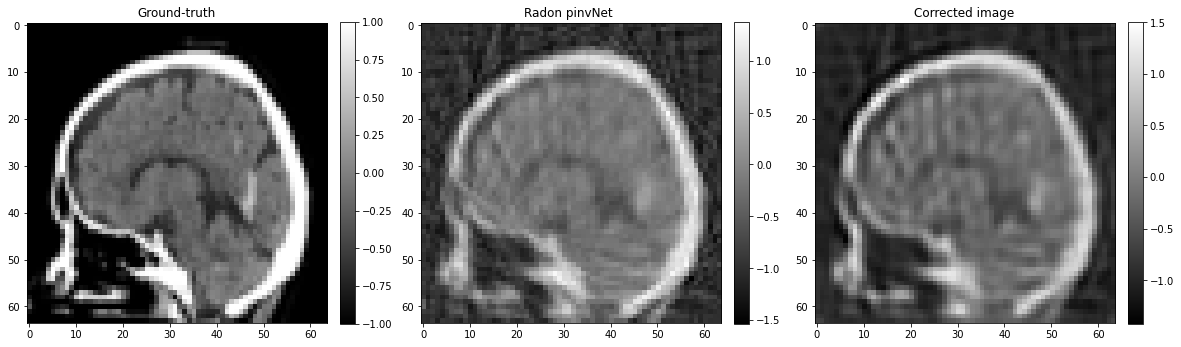

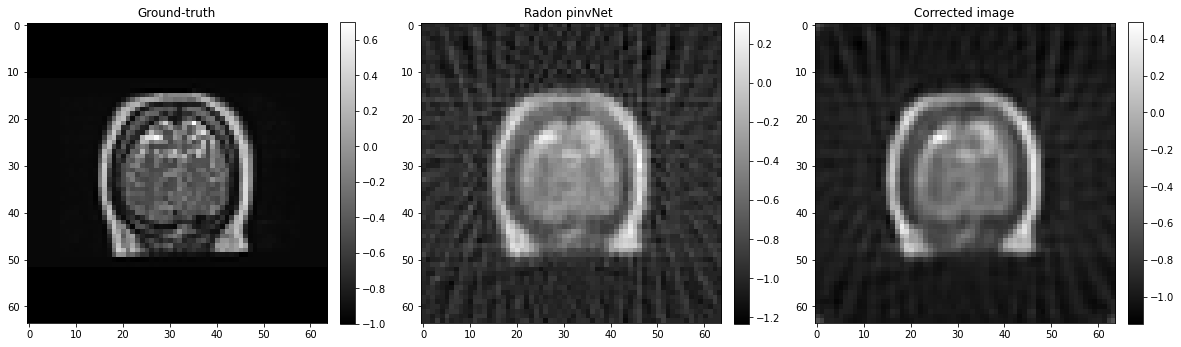

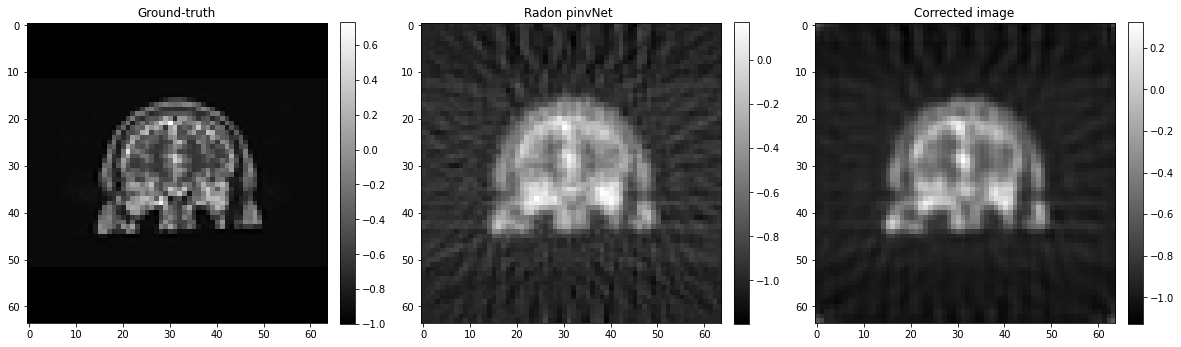

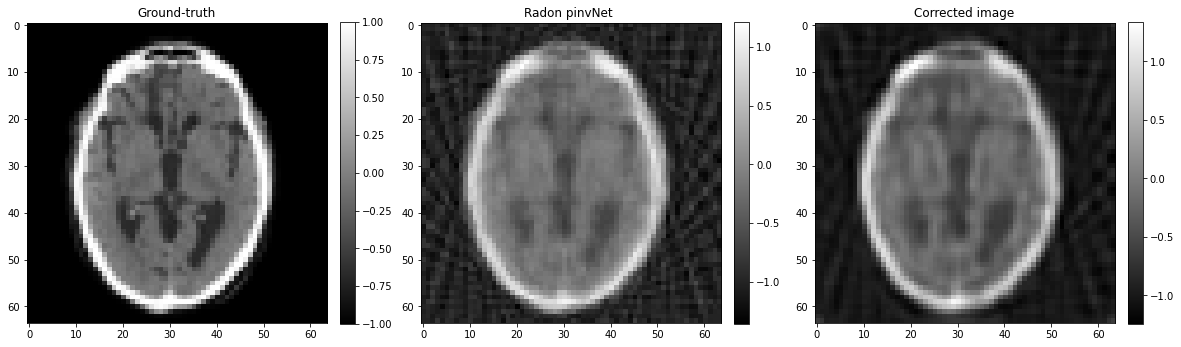

In [24]:
for index in range(test_amt):
    # Choosing random image in STL10
    i_test = np.random.randint(0, inputs.shape[0])
    
    # Plots
    fig, axs = plt.subplots(1, 3, figsize =(20,10))
    fig.suptitle('', fontsize=16)
    
    ax = axs[0]
    ax.set_title("Ground-truth")
    aff = ax.imshow(inputs[i_test, 0, :, :].cpu(), cmap='gray') #Complete here
    fig.colorbar(aff, ax=ax,fraction=0.046,pad=0.04)

    ax = axs[1]
    ax.set_title("Radon pinvNet ")
    rec = model.evaluate_fcl(inputs)
    aff = ax.imshow(rec[i_test, 0, :, :].cpu(), cmap='gray') #Complete here
    fig.colorbar(aff, ax=ax,fraction=0.046,pad=0.04)

    ax = axs[2]
    ax.set_title("Corrected image")
    rec = model.evaluate(inputs)
    aff = ax.imshow(rec[i_test, 0, :, :].cpu(), cmap='gray') #Complete here
    fig.colorbar(aff, ax=ax,fraction=0.046,pad=0.04)
    plt.show()

<font color='blue'>**Q: What seems to be the effect of training the neural network for few epochs?**</font>

<font color='red'>**A: We can see that our reconstructor after a few epochs seems to smooth the image a lot. While this helps remove some artifacts, some still remains. Also we lost most of the details in the reconstructed images since the reconstruction is too smooth.**</font>

## Testing a trained model

In [25]:
net_types = ['c0mp', 'comp','pinv', 'free']
net_arch = 2
num_epoch = 100
list_angles = np.array([20, 40, 60])
learning_rate = 1e-3
step_size = 10
gamma = 0.5
batch_size = 1000
regularisation = 1e-7



test_amt = 4
nbAngles = 20
inputs, labels = next(iter(dataloaders['val']))
inputs = inputs.to(device)

# Deducing model file name
suffix = '_Q_{}_D_{}_T_{}_epo_{}_lr_{}_sss_{}_sdr_{}_bs_{}_reg_{}'.format(\
               img_size, pixel_size, nbAngles, num_epoch, learning_rate, step_size,\
               gamma, batch_size, regularisation)
# title = 'nets/NET_'+ net_types[net_arch] + suffix
title = data_root + 'nets/NET_'+ net_types[net_arch] + suffix

# Loading model
model = model_radon.compNet(img_size, pixel_size, nbAngles, variant=net_arch)
model = model.to(device)
model_out_path = "{}.pth".format(title)
model.load_state_dict(torch.load(model_out_path, map_location=torch.device('cpu')))    


Measurement to image domain: pseudo inverse


<All keys matched successfully>

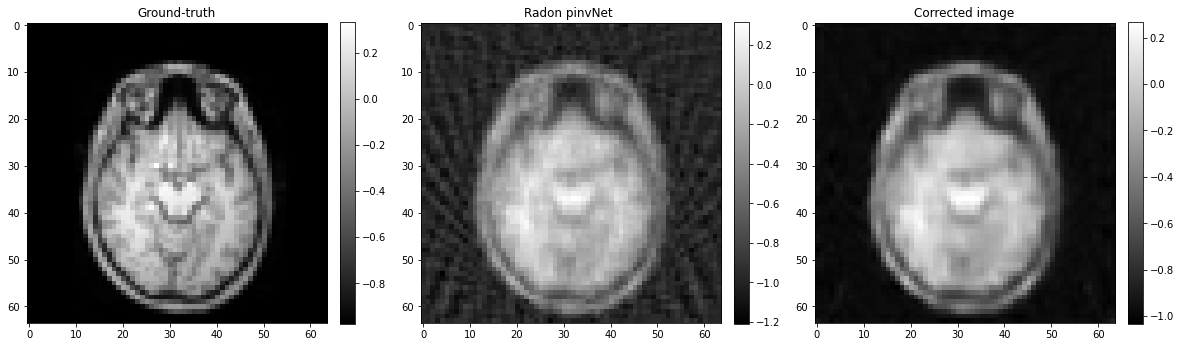

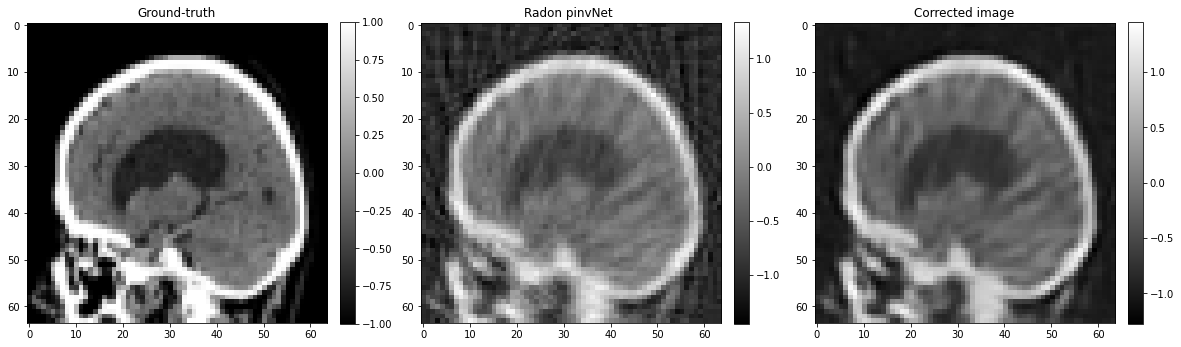

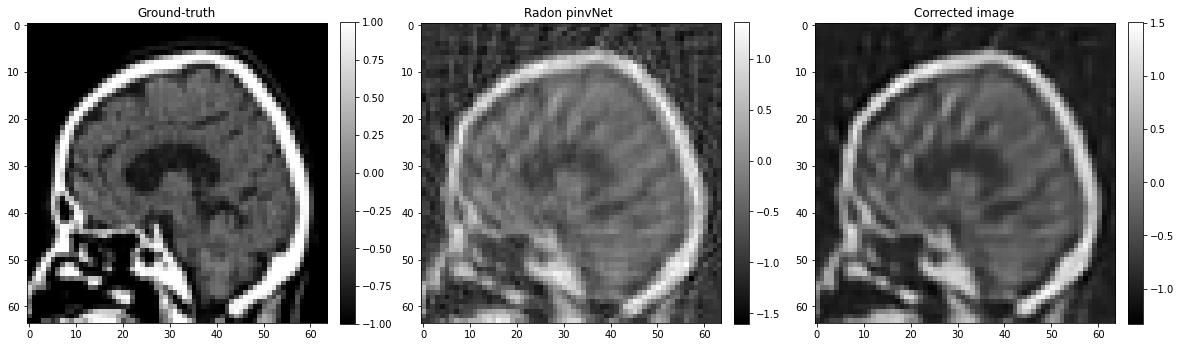

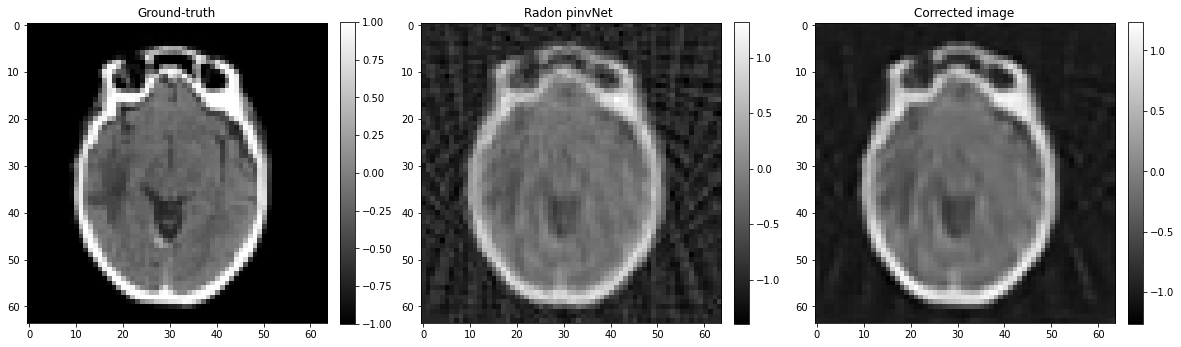

In [26]:
for index in range(test_amt):
    # Choosing random image in STL10
    i_test = np.random.randint(0, inputs.shape[0])
    
    # Plots
    fig, axs = plt.subplots(1, 3, figsize =(20,10))
    fig.suptitle('', fontsize=16)
    
    ax = axs[0]
    ax.set_title("Ground-truth")
    aff = ax.imshow(inputs[i_test, 0, :, :].cpu(), cmap='gray')
    fig.colorbar(aff, ax=ax,fraction=0.046,pad=0.04)

    ax = axs[1]
    ax.set_title("Radon pinvNet ")
    rec = model.evaluate_fcl(inputs)
    aff = ax.imshow(rec[i_test, 0, :, :].cpu(), cmap='gray')
    fig.colorbar(aff, ax=ax,fraction=0.046,pad=0.04)

    ax = axs[2]
    ax.set_title("Corrected image")
    rec = model.evaluate(inputs)
    aff = ax.imshow(rec[i_test, 0, :, :].cpu(), cmap='gray')
    fig.colorbar(aff, ax=ax,fraction=0.046,pad=0.04)
    plt.show()

<font color='blue'>**Q: What is the impact of training a deep neural network until it converges?**</font>

<font color='red'>**A: We can observe that the background seems to possess many fewer artifacts than before, the images while fairly smooth manage to retain many more details than it previously did.**</font>


## Comparing neural Netoworks for several numbers of projections

Acquisition of 20 angles
Measurement to image domain: pseudo inverse


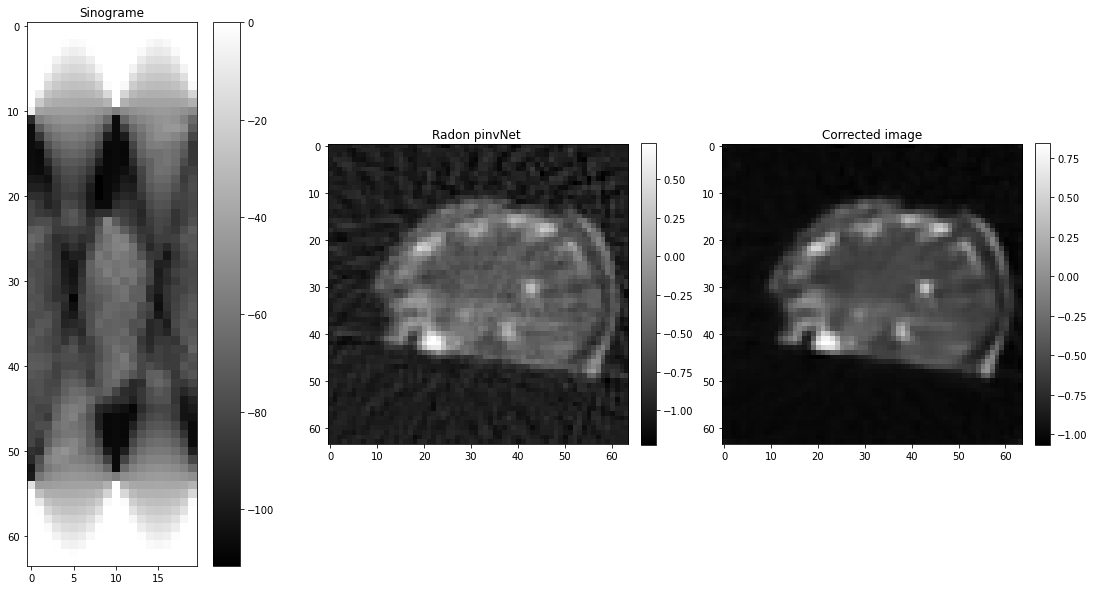

Acquisition of 40 angles
Measurement to image domain: pseudo inverse


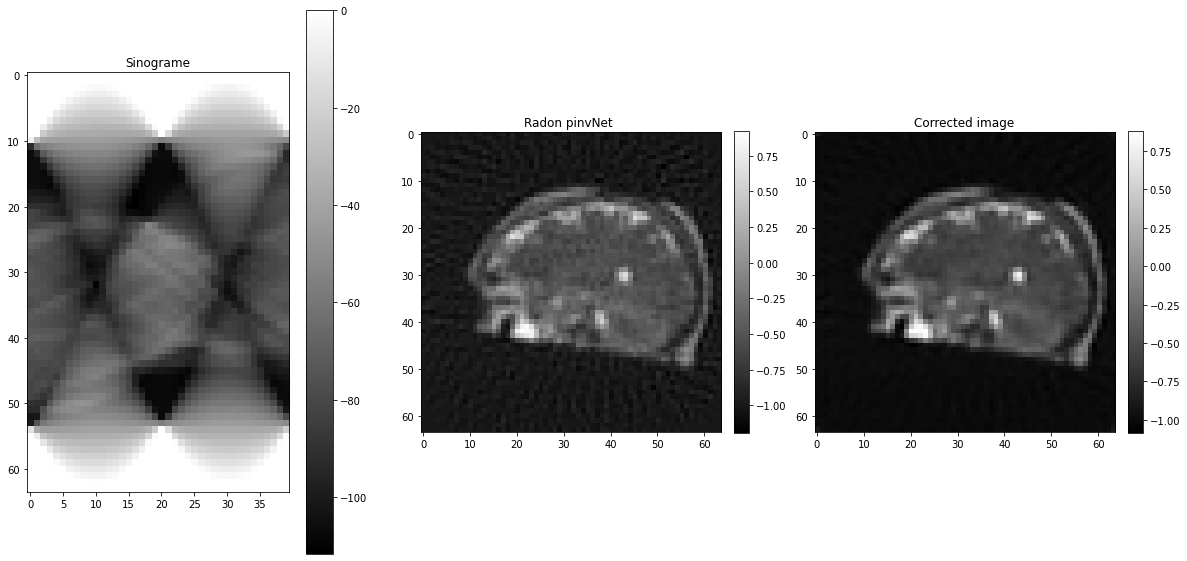

Acquisition of 60 angles
Measurement to image domain: pseudo inverse


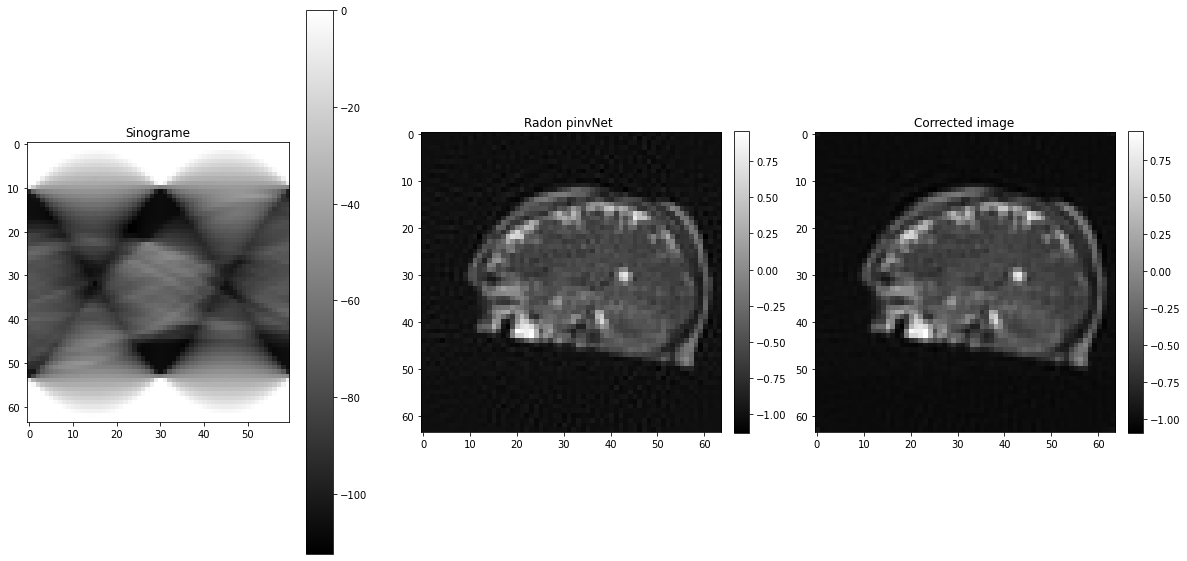

In [27]:
for index in range(list_angles.size):
    print("Acquisition of " + list_angles[index].astype(str) + " angles")
    # Deducing model file name
    suffix = '_Q_{}_D_{}_T_{}_epo_{}_lr_{}_sss_{}_sdr_{}_bs_{}_reg_{}'.format(\
                   img_size, pixel_size, list_angles[index], num_epoch, learning_rate, step_size,\
                   gamma, batch_size, regularisation)
    # title = 'nets/NET_'+ net_types[net_arch] + suffix
    title = data_root + 'nets/NET_'+ net_types[net_arch] + suffix
    
    # loading model
    model = model_radon.compNet(img_size, pixel_size, list_angles[index], variant=net_arch)
    model = model.to(device)
    model_out_path = "{}.pth".format(title)
    model.load_state_dict(torch.load(model_out_path, map_location=torch.device('cpu'))) 
    model_bis = model;
    
    # Plots
    fig, axs = plt.subplots(1, 3, figsize =(20,10))
    fig.suptitle('', fontsize=16)
    
    ax = axs[0]
    ax.set_title("Sinograme")
    rec = model.forward_acquire(inputs, test_batch, color, img_size, img_size)
    rec_array = model_radon.vector2matrix(rec[0, :, 0, 0].cpu(), [list_angles[index], 64])
    aff = ax.imshow(rec_array, cmap='gray')
    fig.colorbar(aff, ax=ax)

    ax = axs[1]
    ax.set_title("Radon pinvNet ")
    rec = model.evaluate_fcl(inputs)
    aff = ax.imshow(rec[0, 0, :, :].cpu(), cmap='gray')
    fig.colorbar(aff, ax=ax,fraction=0.046,pad=0.04)

    ax = axs[2]
    ax.set_title("Corrected image")
    rec = model.evaluate(inputs)
    aff = ax.imshow(rec[0, 0, :, :].cpu(), cmap='gray')
    fig.colorbar(aff, ax=ax,fraction=0.046,pad=0.04)
    plt.show()

<font color='blue'>**Q: Conclude on the limits of Deep-neural reconstructors.**</font>


<font color='red'>**A: When the data is heavily down-sampled, it then even deep-neural reconstructors cannot overcome the resulting artefacts. The students may understand that even imperfect reconstructions are the best one can obtain sometimes.**</font>


# Conclusion
 

At the end of this hands on session, you should be able to :
- Understand the importance of modeling the forward operator of an inverse problem.
- Reconstruct an image from measurement data thanks to linear reconstructors such as the Moore-Penrose pseudo-inverse.
- Reconstruct an image from measurement data thanks to non-linear reconstructors such as convolutional neural networks : the impact of training for a small number of epochs, and how to integrate linear reconstructors to deep-learning methods.
- Understand the limits of reconstruction methods when the data is undersampled.